In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from algorithms import fixed_bitwidth
from model_gen import keras_cnn
from algorithms.optimized_search import OptimizedSearch
import evaluation_metrics

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import pickle

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
# Functions specific to this file
def save_results(scores, acc_drop, opt_params, num):
    
    with open(output_path + f'opt_params_{num}.p', 'wb') as f:
        pickle.dump(opt_params, f)
    
    with open(output_path + f'acc_drop_{num}.p', 'wb') as f:
        pickle.dump(acc_drop, f)
    
    with open(output_path + f'scores_{num}.p', 'wb') as f:
        pickle.dump(scores, f)

In [2]:
input_shape = (28, 28, 1)
num_outputs = 10
num_kernels = 32
num_stages = 7
path_trained_weights = 'C:/Users/320060820/experiments/test_models/mnist_custom/mnist_seq_large_w.h5'
output_path = 'C:/Users/320060820/experiments/outputs/Comp_Dependent_Optimized_Search/Sequential MNIST/'
name = 'mnist_seq_large'
total_acc_drop = 0.005

from test_models.mnist_custom import data
_, test_data = data.get_data()

model_arch = keras_cnn.KerasCNNLarge(input_shape, num_outputs, num_kernels, num_stages, pool_layer_interval = 2, 
                                     path_trained_weights = path_trained_weights)
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]
print(float_model_acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0.995


In [3]:
layer_names = [layer.name for layer in model_obj.model.layers if layer.name.startswith('conv2d') or \
               layer.name.startswith('dense')]
print(layer_names)

['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8', 'conv2d_9', 'conv2d_10', 'conv2d_11', 'conv2d_12', 'conv2d_13', 'conv2d_14', 'dense_1']


### Budget allocation

In [4]:
linear = lambda x, total_acc_drop, num_layers, offset=0: total_acc_drop/num_layers * x + offset

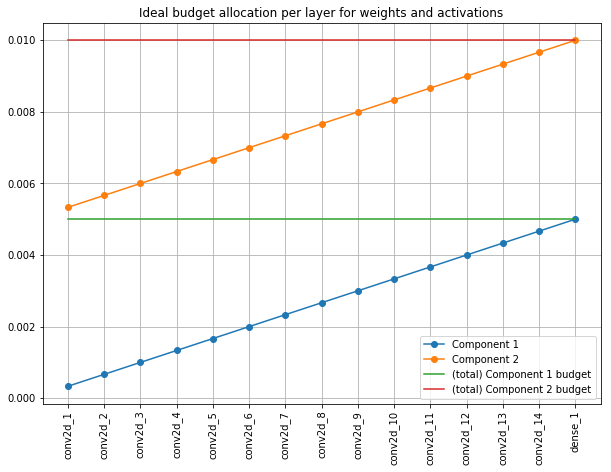

In [5]:
x = np.arange(1, len(layer_names) + 1)
plt.figure(figsize=(10, 7));
plt.title('Ideal budget allocation per layer for weights and activations');
y1 = linear(x, total_acc_drop, len(layer_names))
y2 = linear(x, total_acc_drop, len(layer_names), total_acc_drop)
plt.plot(x, y1, 'o-', label='Component 1');
plt.plot(x, y2, 'o-', label='Component 2');
plt.xticks(x, layer_names, rotation='vertical')
plt.plot(x, np.ones(y2.shape) * total_acc_drop, label='(total) Component 1 budget');
plt.plot(x, np.ones(y2.shape) * total_acc_drop*2, label='(total) Component 2 budget')
plt.grid();
plt.legend();

# Weights (& Biases) - Activations

#### Weights

{'conv2d_1': [12, 13], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 14], 'conv2d_8': [12, 14], 'conv2d_9': [12, 14], 'conv2d_10': [12, 14], 'conv2d_11': [12, 14], 'conv2d_12': [12, 14], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 12]}
Quantizing layer conv2d_1
Global opt: (5, 6) Local opt: (5, 6) Performance diff: 0.000000
Chosen:  (5, 6)
After quantizing weights of layer conv2d_1 | Measured accuracy drop -0.000402 | Acceptable accuracy drop: 0.000333
Quantizing layer conv2d_2
Global opt: (3, 5) Local opt: (4, 6) Performance diff: 0.000302
Chosen:  (3, 5)
After quantizing weights of layer conv2d_2 | Measured accuracy drop -0.000101 | Acceptable accuracy drop: 0.000667
Quantizing layer conv2d_3
Global opt: (2, 3) Local opt: (2, 3) Performance diff: 0.000000
Chosen:  (2, 3)
After quantizing weights of layer conv2d_3 | Measured accuracy drop 0.000302 | Acceptable accuracy drop: 0.001000
Qua

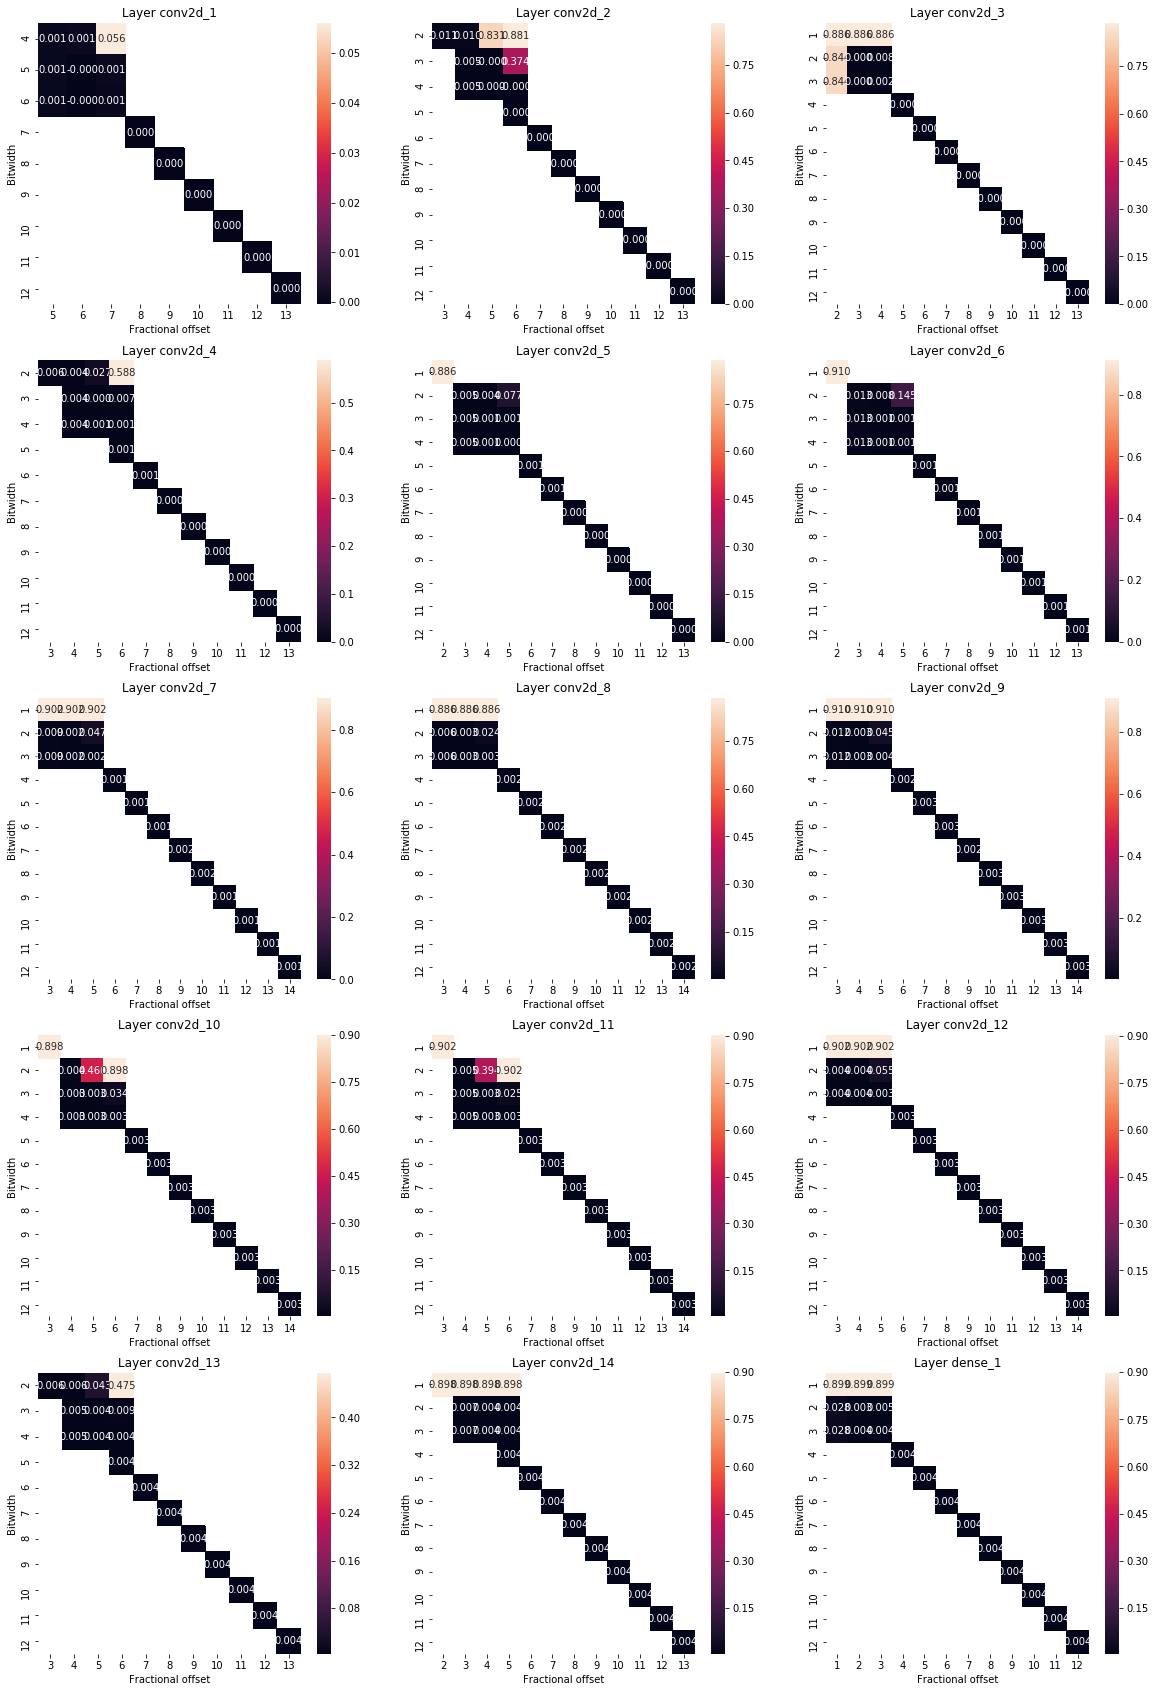

In [6]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(model_arch, name, test_data, float_model_acc)
w_scores, opt_params_weights, acc_drop_w = opts.run(acc_drop_config, 'weights', start_bw = 12)
opts.plot_scores_matrix(w_scores, 5, 3, (20, 30))

In [7]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={'conv2d_1': (5, 6), 'conv2d_2': (3, 5), 'conv2d_3': (2, 3), 'conv2d_4': (3, 5), 'conv2d_5': (3, 4), 'conv2d_6': (3, 4), 'conv2d_7': (2, 4), 'conv2d_8': (2, 4), 'conv2d_9': (2, 4), 'conv2d_10': (3, 5), 'conv2d_11': (3, 5), 'conv2d_12': (2, 4), 'conv2d_13': (3, 5), 'conv2d_14': (2, 4), 'dense_1': (2, 2)}, biases={}, activations={})

#### Biases

In [8]:
acc_drop_config = {
    layer_names[i - 1]: total_acc_drop for i in range(1, len(layer_names) + 1)
}

{'conv2d_1': [8, 12], 'conv2d_2': [8, 12], 'conv2d_3': [8, 12], 'conv2d_4': [8, 11], 'conv2d_5': [8, 11], 'conv2d_6': [8, 11], 'conv2d_7': [8, 11], 'conv2d_8': [8, 11], 'conv2d_9': [8, 11], 'conv2d_10': [8, 11], 'conv2d_11': [8, 11], 'conv2d_12': [8, 11], 'conv2d_13': [8, 11], 'conv2d_14': [8, 10], 'dense_1': [8, 10]}
Quantizing layer conv2d_1
Global opt: (3, 7) Local opt: (3, 7) Performance diff: 0.000000
Chosen:  (3, 7)
After quantizing biases of layer conv2d_1 | Measured accuracy drop 0.003417 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d_2
Global opt: (1, 5) Local opt: (2, 5) Performance diff: 0.000101
Chosen:  (1, 5)
After quantizing biases of layer conv2d_2 | Measured accuracy drop 0.003518 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d_3
Global opt: (1, 5) Local opt: (1, 4) Performance diff: 0.000000
Chosen:  (1, 4)
After quantizing biases of layer conv2d_3 | Measured accuracy drop 0.003518 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d

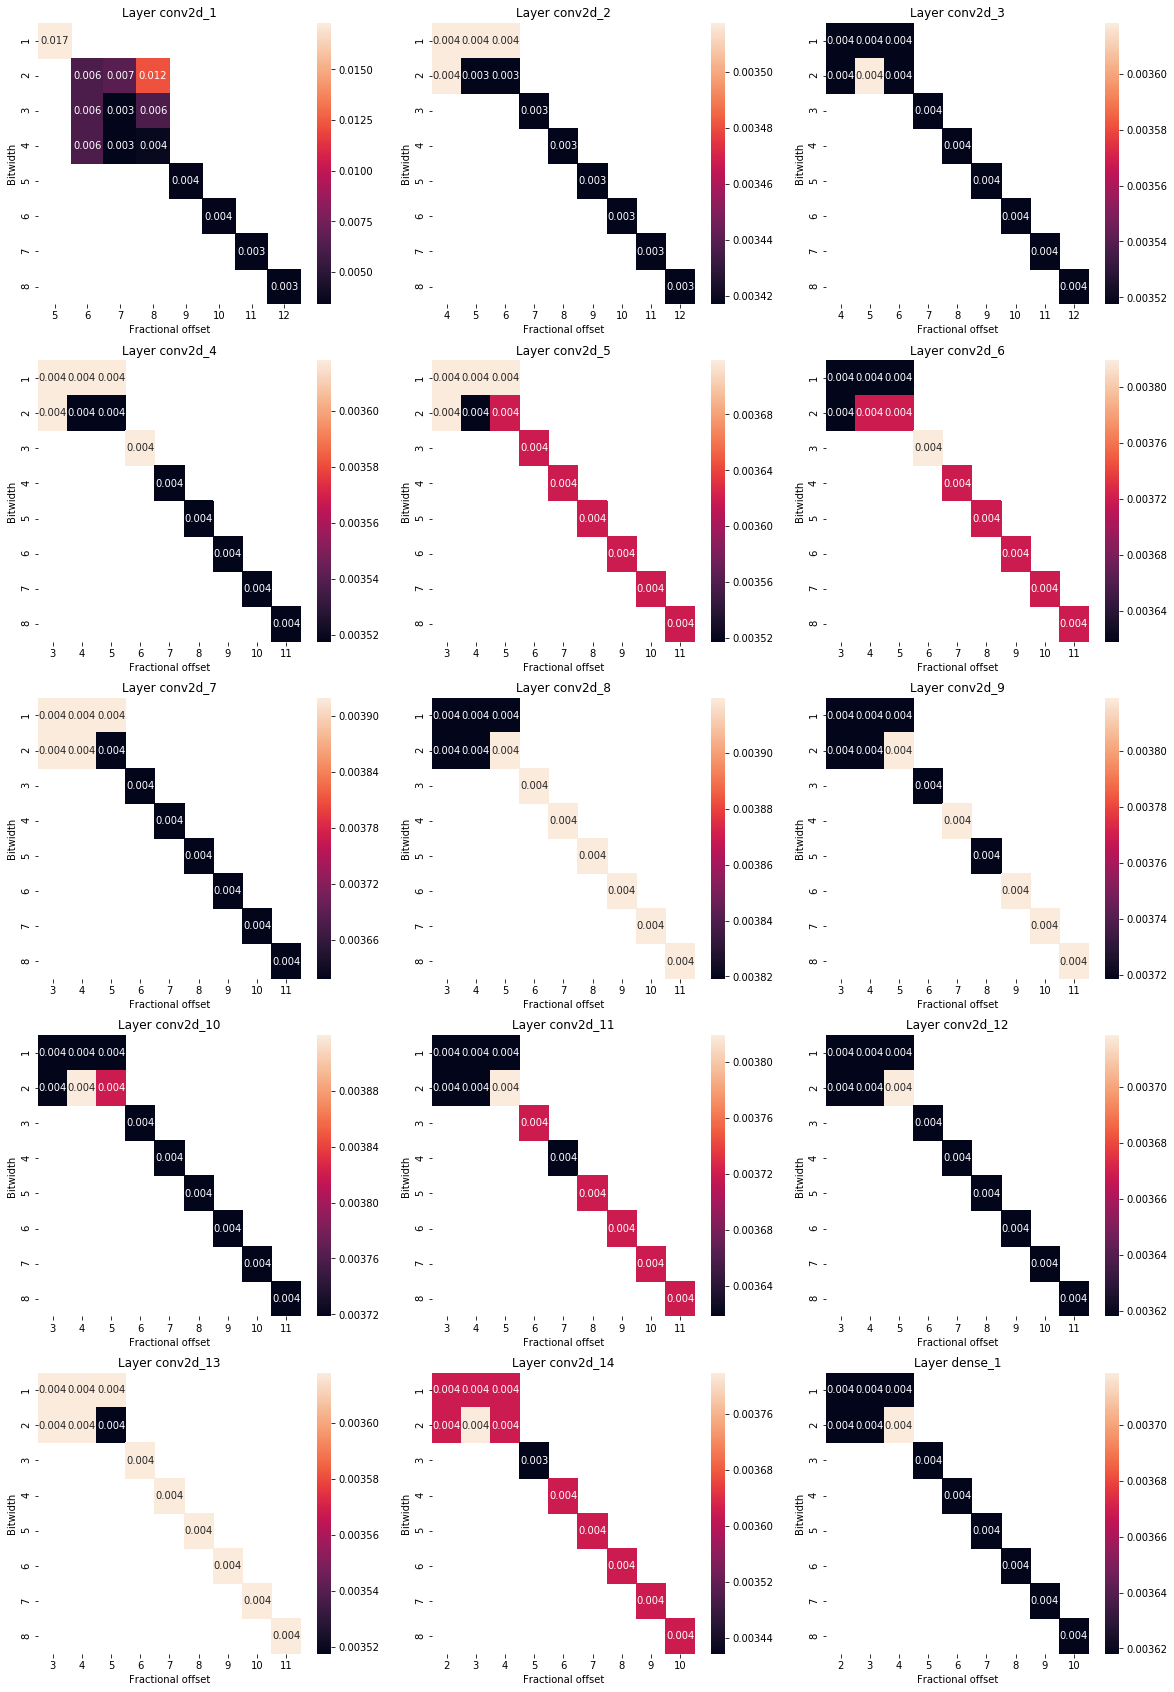

In [9]:
b_scores, opt_params_biases, acc_drop_b = opts.run(acc_drop_config, 'biases', start_bw = 8)
opts.plot_scores_matrix(b_scores, 5, 3, (20, 30))

In [10]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={'conv2d_1': (5, 6), 'conv2d_2': (3, 5), 'conv2d_3': (2, 3), 'conv2d_4': (3, 5), 'conv2d_5': (3, 4), 'conv2d_6': (3, 4), 'conv2d_7': (2, 4), 'conv2d_8': (2, 4), 'conv2d_9': (2, 4), 'conv2d_10': (3, 5), 'conv2d_11': (3, 5), 'conv2d_12': (2, 4), 'conv2d_13': (3, 5), 'conv2d_14': (2, 4), 'dense_1': (2, 2)}, biases={'conv2d_1': (3, 7), 'conv2d_2': (1, 5), 'conv2d_3': (1, 4), 'conv2d_4': (1, 4), 'conv2d_5': (1, 4), 'conv2d_6': (1, 3), 'conv2d_7': (1, 4), 'conv2d_8': (1, 3), 'conv2d_9': (1, 3), 'conv2d_10': (1, 3), 'conv2d_11': (1, 3), 'conv2d_12': (1, 3), 'conv2d_13': (1, 4), 'conv2d_14': (1, 2), 'dense_1': (1, 2)}, activations={})

#### Activations

{'conv2d_1': [12, 11], 'conv2d_2': [12, 8], 'conv2d_3': [12, 7], 'conv2d_4': [12, 7], 'conv2d_5': [12, 7], 'conv2d_6': [12, 7], 'conv2d_7': [12, 8], 'conv2d_8': [12, 7], 'conv2d_9': [12, 7], 'conv2d_10': [12, 7], 'conv2d_11': [12, 7], 'conv2d_12': [12, 7], 'conv2d_13': [12, 7], 'conv2d_14': [12, 7], 'dense_1': [12, 6]}
Quantizing layer conv2d_1
Global opt: (5, 5) Local opt: (6, 6) Performance diff: 0.001508
Chosen:  (6, 6)
After quantizing activations of layer conv2d_1 | Measured accuracy drop 0.003518 | Acceptable accuracy drop: 0.005333
Quantizing layer conv2d_2
Global opt: (4, 2) Local opt: (5, 2) Performance diff: 0.001106
Chosen:  (4, 2)
After quantizing activations of layer conv2d_2 | Measured accuracy drop 0.004422 | Acceptable accuracy drop: 0.005667
Quantizing layer conv2d_3
Global opt: (4, 1) Local opt: (4, 1) Performance diff: 0.000000
Chosen:  (4, 1)
After quantizing activations of layer conv2d_3 | Measured accuracy drop 0.004724 | Acceptable accuracy drop: 0.006000
Quantiz

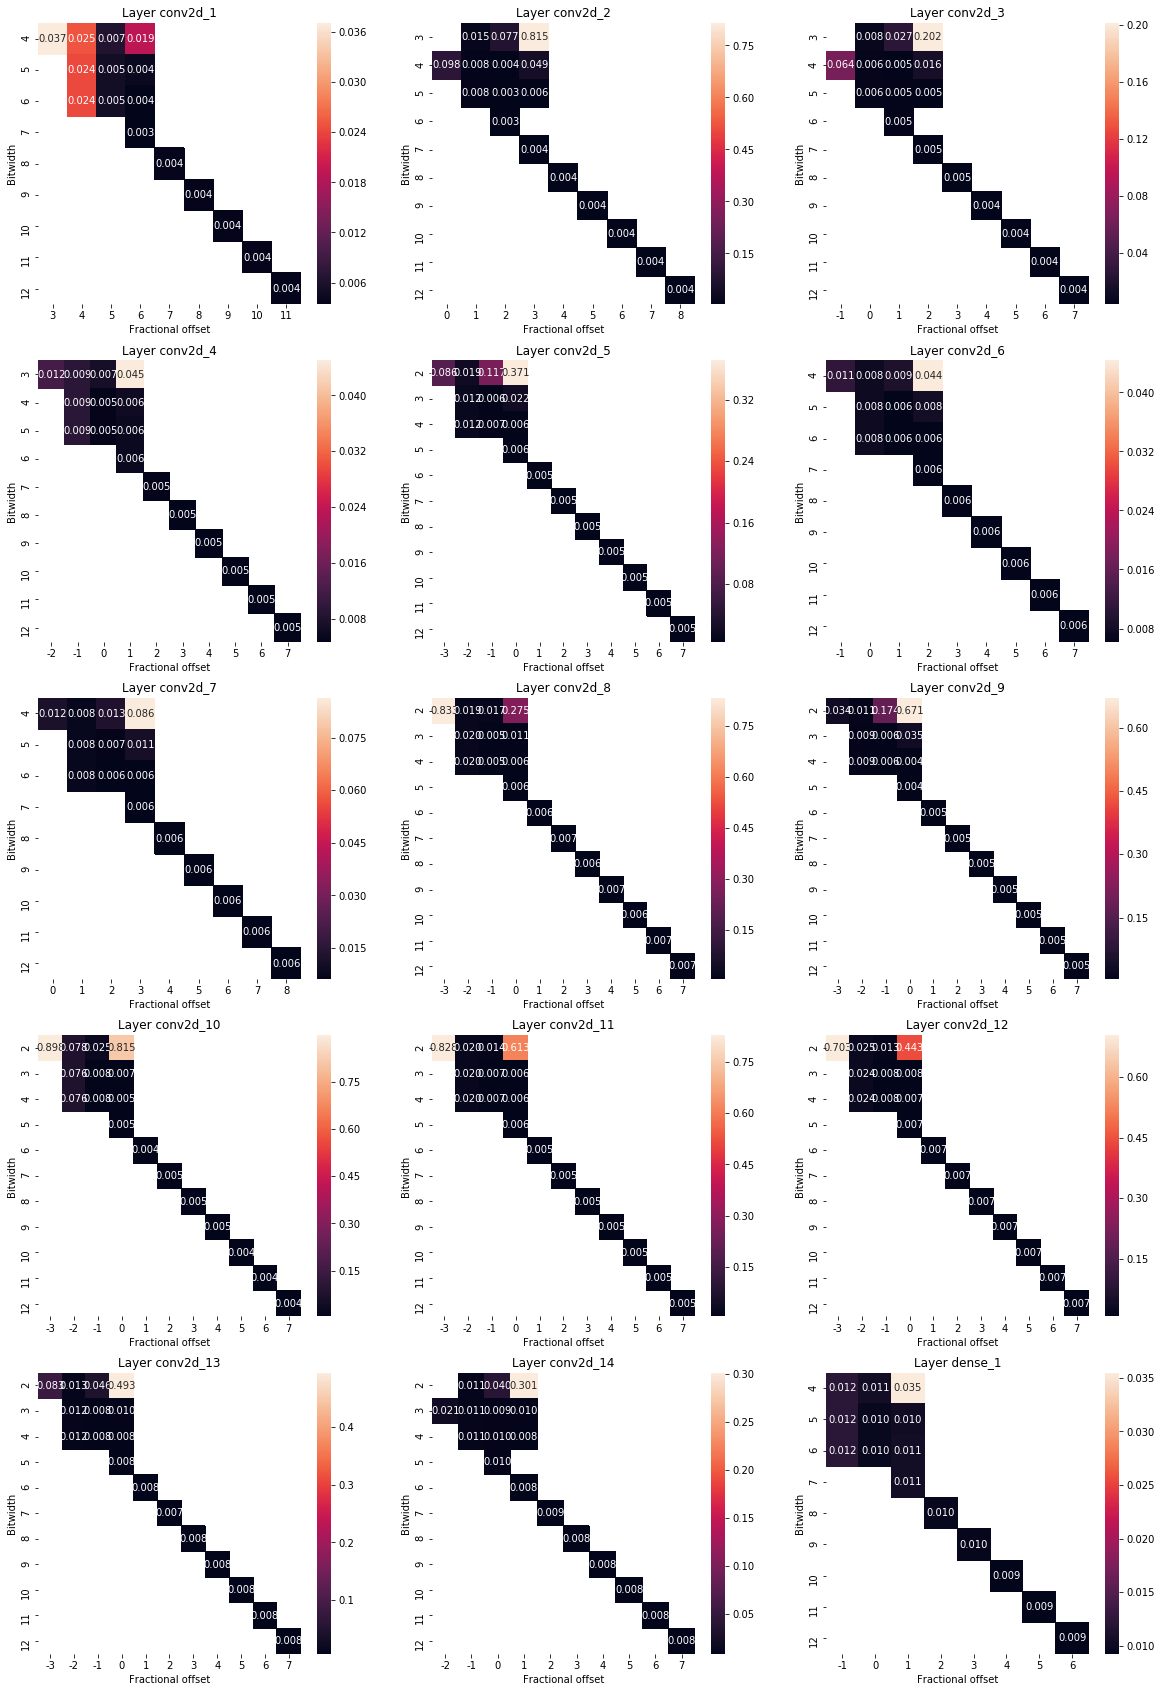

In [11]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names), total_acc_drop) for i in range(1, len(layer_names) + 1)
}

a_scores, opt_params_act, acc_drop_a = opts.run(acc_drop_config, 'activations', start_bw = 12)
opts.plot_scores_matrix(a_scores, 5, 3, (20, 30))

##### Final Quantized Model

In [12]:
model_obj = fxp_quantize.fix_model_quantization(model_arch, name, test_data, opts.quant_evaluator.quant_params)
print(f'Floating point network accuracy: {float_model_acc * 100}%')
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Fixed-point network accuracy: {fxp_model_acc * 100}%')
print(f'Accuracy loss of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f}%')

# Save results
scores = {
    'weights': w_scores,
    'biases': b_scores,
    'activations': a_scores
}
acc_drop = {
    'weights': acc_drop_w,
    'biases': acc_drop_b,
    'activations': acc_drop_a
}

save_results(scores, acc_drop, opts.quant_evaluator.quant_params._asdict(), 1)

Floating point network accuracy: 99.5%
Fixed-point network accuracy: 98.52%
Accuracy loss of 0.985%


In [15]:
memory_consumption = evaluation_metrics.evaluate_memory_consumption(model_obj.model, layer_names, opts.quant_evaluator.quant_params._asdict())
for k in memory_consumption:
    print(f'Memory consumption of {k} (KB): {memory_consumption[k]}')

Memory consumption of weights (KB): 97.08203125
Memory consumption of biases (KB): 0.094970703125
Memory consumption of activations (KB): 69.490478515625


### Plots

In [22]:
def plot_bitwidths(layer_names, opt_params_1, opt_params_2):

    fig, axes = plt.subplots(2, 1, figsize=(20, 15))
    ax = axes.flat
    x = np.arange(1, len(layer_names) + 1, 1)
    width = 0.35
    for i, k in zip(range(len(ax)), ['weights', 'activations']):
        bw_1 = [opt_params_1[k][layer][0] for layer in opt_params_1[k]]
        bw_2 = [opt_params_2[k][layer][0] for layer in opt_params_2[k]]
        ax[i].bar(x, bw_1, width, label='Weights -> Activations')
        ax[i].bar(x + width, bw_2, width, label='Activations -> Weights')
        ax[i].set_xticks(x + width/2)
        ax[i].set_xticklabels(layer_names, rotation=90)
        ax[i].set_xlabel('Layers')
        ax[i].set_ylabel('Bitwidths')
        ax[i].set_title(k)
        ax[i].grid();
        ax[i].legend();

In [23]:
opt_params_1 = opts.quant_evaluator.quant_params._asdict()

# Activations - Weights (& Biases)

#### Activations

{'conv2d_1': [12, 11], 'conv2d_2': [12, 8], 'conv2d_3': [12, 7], 'conv2d_4': [12, 7], 'conv2d_5': [12, 7], 'conv2d_6': [12, 7], 'conv2d_7': [12, 8], 'conv2d_8': [12, 7], 'conv2d_9': [12, 7], 'conv2d_10': [12, 7], 'conv2d_11': [12, 7], 'conv2d_12': [12, 7], 'conv2d_13': [12, 7], 'conv2d_14': [12, 7], 'dense_1': [12, 6]}
Quantizing layer conv2d_1
Global opt: (7, 7) Local opt: (7, 7) Performance diff: 0.000000
Chosen:  (7, 7)
After quantizing activations of layer conv2d_1 | Measured accuracy drop -0.000101 | Acceptable accuracy drop: 0.000333
Quantizing layer conv2d_2
Global opt: (5, 2) Local opt: (6, 3) Performance diff: 0.000302
Chosen:  (5, 2)
After quantizing activations of layer conv2d_2 | Measured accuracy drop 0.000302 | Acceptable accuracy drop: 0.000667
Quantizing layer conv2d_3
Global opt: (3, 0) Local opt: (4, 0) Performance diff: 0.000503
Chosen:  (3, 0)
After quantizing activations of layer conv2d_3 | Measured accuracy drop 0.000603 | Acceptable accuracy drop: 0.001000
Quanti

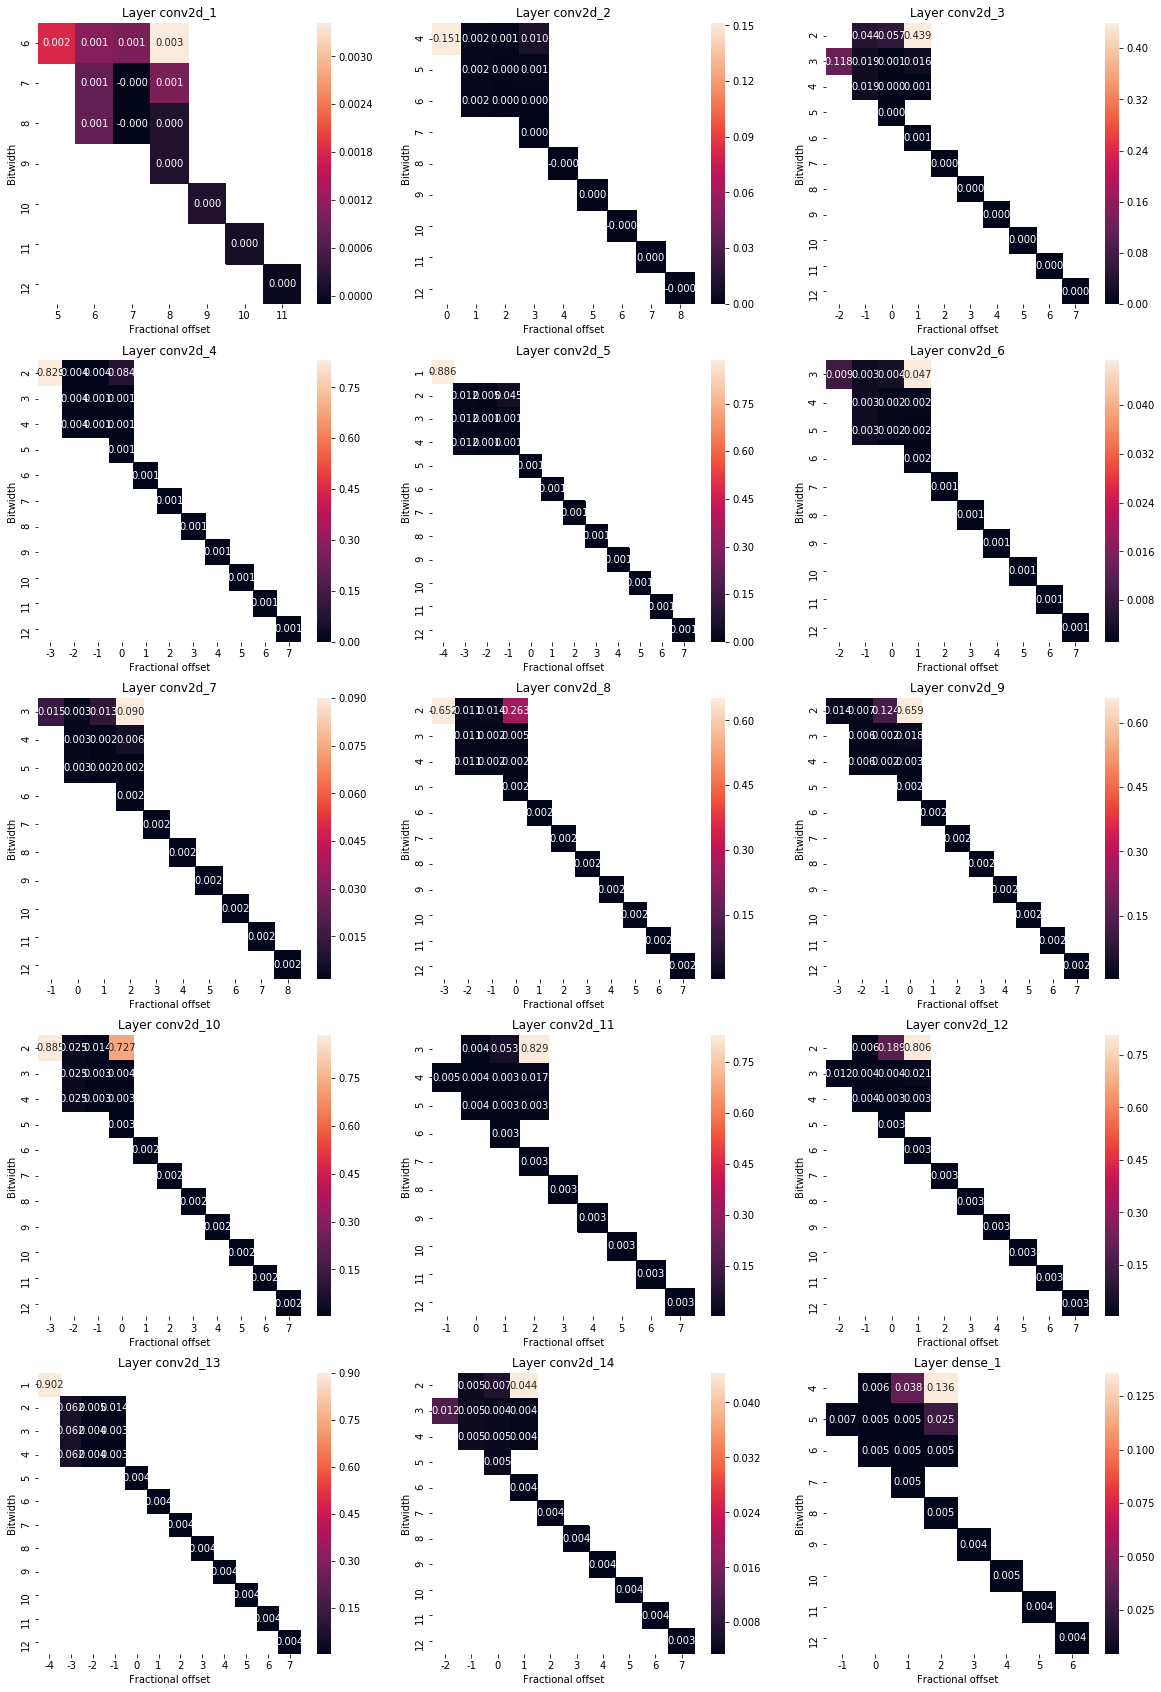

In [24]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(model_arch, name, test_data, float_model_acc)
a_scores, opt_params_act, acc_drop_a = opts.run(acc_drop_config, 'activations', start_bw = 12)
opts.plot_scores_matrix(a_scores, 5, 3, (20, 30))

In [25]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={}, biases={}, activations={'conv2d_1': (7, 7), 'conv2d_2': (5, 2), 'conv2d_3': (3, 0), 'conv2d_4': (3, -1), 'conv2d_5': (3, -2), 'conv2d_6': (4, 0), 'conv2d_7': (4, 1), 'conv2d_8': (3, -1), 'conv2d_9': (3, -1), 'conv2d_10': (3, -1), 'conv2d_11': (4, 1), 'conv2d_12': (3, 0), 'conv2d_13': (3, -1), 'conv2d_14': (3, 0), 'dense_1': (5, 1)})

#### Weights

In [34]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names), total_acc_drop) for i in range(1, len(layer_names) + 1)
}

w_scores, opt_params_weights, acc_drop_w = opts.run(acc_drop_config, 'weights', start_bw = 12)
if not isinstance(w_scores, int):
    opts.plot_scores_matrix(w_scores, 5, 3, (20, 30))

{'conv2d_1': [12, 13], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 14], 'conv2d_8': [12, 14], 'conv2d_9': [12, 14], 'conv2d_10': [12, 14], 'conv2d_11': [12, 14], 'conv2d_12': [12, 14], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 12]}
Quantizing layer conv2d_1
No suitable points found. Try a larger starting bitwidth or increase the max_acc_drop threshold for layer conv2d_1
max_acc_drop: 0.005333 | collected values: [0.00643216 0.00582915]| bitwidths: [11 12], fractional_offsets: [12 13]


In [36]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={}, biases={}, activations={'conv2d_1': (7, 7), 'conv2d_2': (5, 2), 'conv2d_3': (3, 0), 'conv2d_4': (3, -1), 'conv2d_5': (3, -2), 'conv2d_6': (4, 0), 'conv2d_7': (4, 1), 'conv2d_8': (3, -1), 'conv2d_9': (3, -1), 'conv2d_10': (3, -1), 'conv2d_11': (4, 1), 'conv2d_12': (3, 0), 'conv2d_13': (3, -1), 'conv2d_14': (3, 0), 'dense_1': (5, 1)})

#### Biases

In [37]:
# multiplied by 2 to assign same budget as that for weights
acc_drop_config = {
    layer_names[i - 1]: total_acc_drop * 2 for i in range(1, len(layer_names) + 1)
}

b_scores, opt_params_biases, acc_drop_b = opts.run(acc_drop_config, 'biases', start_bw = 8)
opts.plot_scores_matrix(b_scores, 5, 3, (20, 30))

{'conv2d_1': [8, 12], 'conv2d_2': [8, 12], 'conv2d_3': [8, 12], 'conv2d_4': [8, 11], 'conv2d_5': [8, 11], 'conv2d_6': [8, 11], 'conv2d_7': [8, 11], 'conv2d_8': [8, 11], 'conv2d_9': [8, 11], 'conv2d_10': [8, 11], 'conv2d_11': [8, 11], 'conv2d_12': [8, 11], 'conv2d_13': [8, 11], 'conv2d_14': [8, 10], 'dense_1': [8, 10]}
Quantizing layer conv2d_1
No suitable points found. Try a larger starting bitwidth or increase the max_acc_drop threshold for layer conv2d_1
max_acc_drop: 0.005000 | collected values: [0.00633166 0.0081407 ]| bitwidths: [7 8], fractional_offsets: [11 12]


TypeError: 'int' object is not iterable

In [ ]:
opts.quant_evaluator.quant_params

##### Final Quantized Model

In [95]:
model_obj = fxp_quantize.fix_model_quantization(model_arch, name, test_data, opts.quant_evaluator.quant_params)
print(f'Floating point network accuracy: {float_model_acc * 100}%')
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Fixed-point network accuracy: {fxp_model_acc * 100}%')
print(f'Accuracy loss of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f}%')

# Save results
scores = {
    'weights': w_scores,
    'biases': b_scores,
    'activations': a_scores
}
acc_drop = {
    'weights': acc_drop_w,
    'biases': acc_drop_b,
    'activations': acc_drop_a
}

save_results(scores, acc_drop, opts.quant_evaluator.quant_params._asdict(), 2)

Floating point network accuracy: 99.5%
Fixed-point network accuracy: 98.6%
Accuracy loss of 0.905%


In [107]:
memory_consumption = evaluate_memory_consumption(model_obj, layer_names, opts.quant_evaluator.quant_params)
for k in memory_consumption:
    print(f'Memory consumption of {k} (KB): {memory_consumption[k]}')

Memory consumption of Weights (KB): 97.08203125
Memory consumption of Biases (KB): 0.094970703125
Memory consumption of Activations (KB): 0.338134765625


# Comparison

In [ ]:
# Bitwidth comparison

In [ ]:
# Memory consumption comparison

In [ ]:
# Accuracy drop comparison